# This script processes the file All_Optimizations.csv  

1. Generate the file All_Optimizations.txt by running:
    1. process_baseline_results.ipynb (for Baseline)
    2. process_opt1_results.ipynb (for Opt1-Quadtree)
    3. process_o2_partree_results.ipynb (for Opt2-parallization)
    4. process_o3_memo_results.ipynb (for Opt3-memoization)
    5. process_o4minrad_maxnum.ipynb (for Opt4-minradius and maxnumber optimizations)

2. Run the next cells in this notebook...

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd

df=pd.read_csv('All_Optimizations.csv',sep=';')
df.insert(4,"Total",0)
df['Total']=df['TimeTree']+df['TimeOWM']
df

,Optimization,Cloud,TimeTree,TimeOWM,Total,Level,MinRadMaxNum
0,Baseline,Alcoy,4.737780,3.733700,8.471480,0,0.0
1,Baseline,Arzua,5.749600,4.105800,9.855400,0,0.0
2,Baseline,BrionF,5.971560,6.233900,12.205460,0,0.0
3,Baseline,BrionU,6.761090,7.327300,14.088390,0,0.0
4,Opt1-Quadtree,Alcoy,3.180970,1.981200,5.162170,0,0.0
5,Opt1-Quadtree,Arzua,3.772510,1.699800,5.472310,0,0.0
6,Opt1-Quadtree,BrionF,4.025610,3.072000,7.097610,0,0.0
7,Opt1-Quadtree,BrionU,4.495810,3.889300,8.385110,0,0.0
8,Opt2-Par,Alcoy,0.507530,1.857490,2.365020,7,0.0
9,Opt2-Par,Arzua,0.683820,1.381410,2.065230,7,0.0


In [7]:
base=df.loc[0:3,'TimeTree':'Total']
best=df.loc[28:31,'TimeTree':'Total']
print(base)
print(best)

   TimeTree  TimeOWM     Total
0   4.73778   3.7337   8.47148
1   5.74960   4.1058   9.85540
2   5.97156   6.2339  12.20546
3   6.76109   7.3273  14.08839
    TimeTree   TimeOWM     Total
28  0.167986  0.275714  0.443700
29  0.329102  0.270224  0.599326
30  0.805900  0.283117  1.089017
31  0.833301  0.343903  1.177204


In [8]:
b=np.array(base)
c=np.array(best)
speedup=b/c
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}x".format(x)})
#Print total speedup for each cloud (one cloud per row, one column for ech time measurement)
print(speedup)

[[28.20x 13.54x 19.09x]
 [17.47x 15.19x 16.44x]
 [7.41x 22.02x 11.21x]
 [8.11x 21.31x 11.97x]]


# Speedup of each optimization w.r.t. the previous one

In [9]:
df['TreeSp']=1
df['OWMSp']=1
df['TotalSp']=1

#Speedup of one optimization w.r.t. the previous one
for i in range(4,len(df)):
    df.loc[i,'TreeSp']=df['TimeTree'][i-4]/df['TimeTree'][i]
    df.loc[i,'OWMSp']=df['TimeOWM'][i-4]/df['TimeOWM'][i]
    df.loc[i,'TotalSp']=df['Total'][i-4]/df['Total'][i]
df

,Optimization,Cloud,TimeTree,TimeOWM,Total,Level,MinRadMaxNum,TreeSp,OWMSp,TotalSp
0,Baseline,Alcoy,4.737780,3.733700,8.471480,0,0.0,1.000000,1.000000,1.000000
1,Baseline,Arzua,5.749600,4.105800,9.855400,0,0.0,1.000000,1.000000,1.000000
2,Baseline,BrionF,5.971560,6.233900,12.205460,0,0.0,1.000000,1.000000,1.000000
3,Baseline,BrionU,6.761090,7.327300,14.088390,0,0.0,1.000000,1.000000,1.000000
4,Opt1-Quadtree,Alcoy,3.180970,1.981200,5.162170,0,0.0,1.489414,1.884565,1.641070
5,Opt1-Quadtree,Arzua,3.772510,1.699800,5.472310,0,0.0,1.524078,2.415461,1.800958
6,Opt1-Quadtree,BrionF,4.025610,3.072000,7.097610,0,0.0,1.483393,2.029264,1.719658
7,Opt1-Quadtree,BrionU,4.495810,3.889300,8.385110,0,0.0,1.503865,1.883964,1.680168
8,Opt2-Par,Alcoy,0.507530,1.857490,2.365020,7,0.0,6.267551,1.066601,2.182717
9,Opt2-Par,Arzua,0.683820,1.381410,2.065230,7,0.0,5.516817,1.230482,2.649734


# Important notice

**The sum of the relative speedups (one optim. wrt the previous one) is not the total speedup**

In [11]:
df.groupby('Cloud').sum().drop(['TimeTree','TimeOWM','Total','Level','MinRadMaxNum'],axis=1)

/var/folders/3m/wbwr7b111j5gzwwf_cf38xwc0000gn/T/ipykernel_56467/1665443844.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('Cloud').sum().drop(['TimeTree','TimeOWM','Total','Level','MinRadMaxNum'],axis=1)


,TreeSp,OWMSp,TotalSp
Cloud,,,
Alcoy,15.916737,11.408096,12.140386
Arzua,14.138293,11.702269,11.982980
BrionF,12.607576,12.601172,11.486564
BrionU,12.515869,12.552443,11.550221


# Speedup of each optimization w.r.t. baseline

In [12]:
#Speedup of one optimization w.r.t. baseline
for i in range(4,len(df),4):
    for j in range(4):
        df.loc[i+j,'TreeSp']=df['TimeTree'][j]/df['TimeTree'][i+j]
        df.loc[i+j,'OWMSp']=df['TimeOWM'][j]/df['TimeOWM'][i+j]
        df.loc[i+j,'TotalSp']=df['Total'][j]/df['Total'][i+j]
df

,Optimization,Cloud,TimeTree,TimeOWM,Total,Level,MinRadMaxNum,TreeSp,OWMSp,TotalSp
0,Baseline,Alcoy,4.737780,3.733700,8.471480,0,0.0,1.000000,1.000000,1.000000
1,Baseline,Arzua,5.749600,4.105800,9.855400,0,0.0,1.000000,1.000000,1.000000
2,Baseline,BrionF,5.971560,6.233900,12.205460,0,0.0,1.000000,1.000000,1.000000
3,Baseline,BrionU,6.761090,7.327300,14.088390,0,0.0,1.000000,1.000000,1.000000
4,Opt1-Quadtree,Alcoy,3.180970,1.981200,5.162170,0,0.0,1.489414,1.884565,1.641070
5,Opt1-Quadtree,Arzua,3.772510,1.699800,5.472310,0,0.0,1.524078,2.415461,1.800958
6,Opt1-Quadtree,BrionF,4.025610,3.072000,7.097610,0,0.0,1.483393,2.029264,1.719658
7,Opt1-Quadtree,BrionU,4.495810,3.889300,8.385110,0,0.0,1.503865,1.883964,1.680168
8,Opt2-Par,Alcoy,0.507530,1.857490,2.365020,7,0.0,9.334975,2.010078,3.581991
9,Opt2-Par,Arzua,0.683820,1.381410,2.065230,7,0.0,8.408061,2.972181,4.772059


In [20]:
df[df['Cloud']=='BrionF']['OWMSp']

2      1.000000
6      2.029264
10     3.313120
14     5.237691
18    14.940443
22    22.546566
26    19.307950
30    22.018812
Name: OWMSp, dtype: float64

In [15]:
df[df['Cloud']=='Alcoy']['OWMSp']/13.541931*100

0       7.384471
4      13.916515
8      14.843364
12     23.298462
16     31.740152
20     49.091751
24     93.965968
28    100.000001
Name: OWMSp, dtype: float64

# Improvement Factor for each cloud

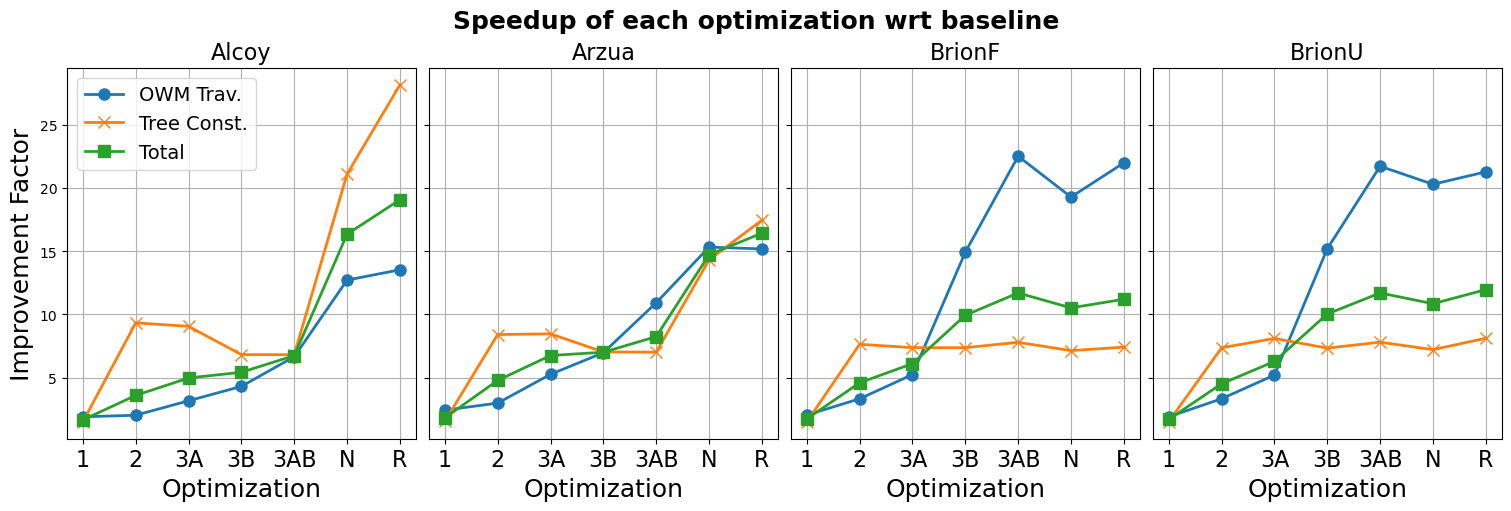

In [19]:
def plot_allsp(df):
    #Configuration variables
    titlefs = 20
    ylabelfs = 18
    xlabelfs = 18
    xticksfs = 16
    yticksfs = 16
    legendfs = 14
    linew = 2
    markers = 8
    marks=['o-','x-','s-','v-','+-']

    all=np.array(df.loc[4:,'TreeSp':'TotalSp'])
    clouds=list(df.loc[0:3,'Cloud'])
    bycloud={}
    for i,j in zip(clouds,range(len(clouds))):
        bycloud[i]=all[j::4].T

    #fig = plt.figure()
    labels=['OWM Trav.','Tree Const.','Total']
    x=np.arange(1,8)
    xlab=['1','2','3A','3B','3AB','N','R']
    #define grid of plots
    fig, axs = plt.subplots(nrows=1, ncols=4,figsize=(15, 5), constrained_layout=True, sharey=True)
    for i,name in zip(range(len(clouds)),clouds):
        axs[i].plot(x, bycloud[name][1], marks[0], linewidth=linew, markersize=markers)
        axs[i].plot(x, bycloud[name][0], marks[1], linewidth=linew, markersize=markers)
        axs[i].plot(x, bycloud[name][2], marks[2], linewidth=linew, markersize=markers)

        axs[i].set_title(name,fontsize=16)
        axs[i].set_xlabel('Optimization', fontsize=xlabelfs)
        axs[i].set_xticks(x,labels=xlab,fontsize=xticksfs)
        # axs[i].yticks(fontsize=yticksfs)
        axs[i].grid()
    fig.suptitle('Improvement factor of each optimization wrt baseline',  fontweight='bold', fontsize=18)
    
    axs[0].set_ylabel('Improvement Factor', fontsize=ylabelfs)
    axs[0].legend(labels,loc='best', fontsize= 14)
    pp = PdfPages("Speedup_all_optim.pdf")
    pp.savefig(fig)
    pp.close()
    #axs[i].show()

plot_allsp(df)

In [21]:
all=np.array(df.loc[4:,'TreeSp':'TotalSp'])
clouds=list(df.loc[0:3,'Cloud'])
bycloud={}
for i,j in zip(clouds,range(len(clouds))):
    bycloud[i]=all[j::4]
bycloud    
#bycloud['Alcoy'][1]
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}%".format(x)})
for i in clouds:
    bycloud[i]=bycloud[i]/bycloud[i][-1]*100
    #print(bycloud[i])
print("Adapt for stacked bar plot")    
for i in clouds:
    for j in range(3,0,-1):
        bycloud[i][j]=bycloud[i][j]-bycloud[i][j-1]
    print(bycloud[i])
# allcloudstack=bycloud['Alcoy']#[:,0:2]
# for i in clouds[1:]:
#     allcloudstack=np.hstack((allcloudstack,bycloud[i]))
# allcloudstack[0][0::3]    
#allcloudstack.transpose(2,1,0)    
bycloud
#here the order of the indices are cloud, optimization,time
all=np.array([bycloud[x] for x in clouds])
all.shape
#see this to understand the transpose https://stackoverflow.com/questions/32034237/how-does-numpys-transpose-method-permute-the-axes-of-an-array
#now the order of the indices are time, optimization, cloud
all=all.transpose(2,1,0)

all

   

Adapt for stacked bar plot
[[5.28% 13.92% 8.60%]
 [27.82% 0.93% 10.17%]
 [-0.98% 8.46% 7.24%]
 [-7.96% 8.44% 2.37%]
 [24.15% 49.09% 35.29%]
 [74.94% 93.97% 85.72%]
 [100.00% 100.00% 100.00%]]
[[8.72% 15.90% 10.95%]
 [39.40% 3.66% 18.07%]
 [0.31% 15.01% 12.00%]
 [-8.20% 11.30% 1.58%]
 [40.13% 71.92% 50.12%]
 [82.00% 100.97% 89.59%]
 [100.00% 100.00% 100.00%]]
[[20.02% 9.22% 15.34%]
 [83.03% 5.83% 25.54%]
 [-3.62% 8.74% 13.55%]
 [-0.04% 44.07% 34.24%]
 [105.15% 102.40% 104.42%]
 [96.27% 87.69% 93.88%]
 [100.00% 100.00% 100.00%]]
[[18.54% 8.84% 14.04%]
 [72.15% 6.73% 23.61%]
 [9.12% 8.79% 14.76%]
 [-9.43% 47.03% 31.45%]
 [96.15% 102.09% 97.81%]
 [88.86% 95.36% 90.67%]
 [100.00% 100.00% 100.00%]]


array([[[5.28%, 8.72%, 20.02%, 18.54%],
        [27.82%, 39.40%, 83.03%, 72.15%],
        [-0.98%, 0.31%, -3.62%, 9.12%],
        [-7.96%, -8.20%, -0.04%, -9.43%],
        [24.15%, 40.13%, 105.15%, 96.15%],
        [74.94%, 82.00%, 96.27%, 88.86%],
        [100.00%, 100.00%, 100.00%, 100.00%]],

       [[13.92%, 15.90%, 9.22%, 8.84%],
        [0.93%, 3.66%, 5.83%, 6.73%],
        [8.46%, 15.01%, 8.74%, 8.79%],
        [8.44%, 11.30%, 44.07%, 47.03%],
        [49.09%, 71.92%, 102.40%, 102.09%],
        [93.97%, 100.97%, 87.69%, 95.36%],
        [100.00%, 100.00%, 100.00%, 100.00%]],

       [[8.60%, 10.95%, 15.34%, 14.04%],
        [10.17%, 18.07%, 25.54%, 23.61%],
        [7.24%, 12.00%, 13.55%, 14.76%],
        [2.37%, 1.58%, 34.24%, 31.45%],
        [35.29%, 50.12%, 104.42%, 97.81%],
        [85.72%, 89.59%, 93.88%, 90.67%],
        [100.00%, 100.00%, 100.00%, 100.00%]]])

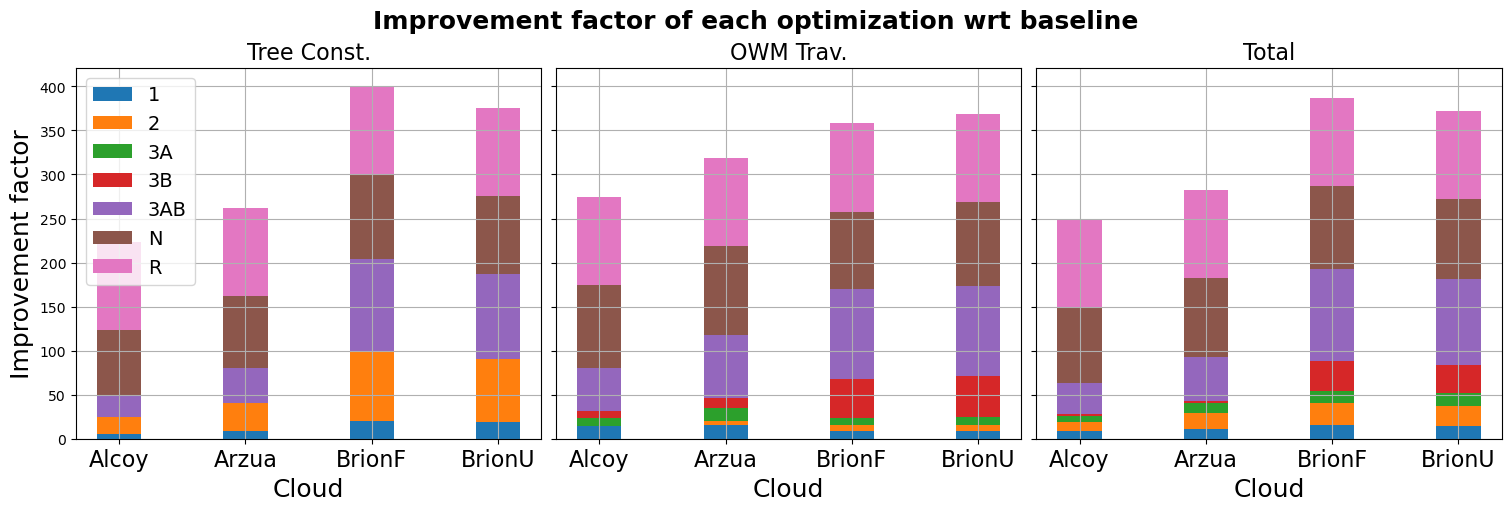

In [24]:
def plot_allsp100(npa):
    #Configuration variables
    titlefs = 20
    ylabelfs = 18
    xlabelfs = 18
    xticksfs = 16
    yticksfs = 16
    legendfs = 14
    linew = 2
    markers = 8
    marks=['o-','x-','s-','v-','+-']


    #fig = plt.figure()
    plots=['Tree Const.','OWM Trav.','Total']
    clouds=['Alcoy','Arzua','BrionF','BrionU']
    x=np.arange(1,len(clouds)+1)
    optim=['1','2','3A','3B','3AB','N','R']
    width=0.35
    #define grid of plots
    fig, axs = plt.subplots(nrows=1, ncols=3,figsize=(15, 5), constrained_layout=True, sharey=True)
    for i,name in zip(range(len(plots)),plots):
        b=np.zeros(len(clouds))
        for j,z in zip(optim,range(len(optim))):
            axs[i].bar(x, npa[i][z], width, label=j, bottom=b)
            b=b+npa[i][z]

        axs[i].set_title(name,fontsize=16)
        axs[i].set_xlabel('Cloud', fontsize=xlabelfs)
        axs[i].set_xticks(x,labels=clouds,fontsize=xticksfs)
        # axs[i].yticks(fontsize=yticksfs)
        axs[i].grid()
    fig.suptitle('Improvement factor of each optimization wrt baseline',  fontweight='bold', fontsize=18)
    
    axs[0].set_ylabel('Improvement factor', fontsize=ylabelfs)
    axs[0].legend(optim,loc='best', fontsize= 14)
    pp = PdfPages("Speedup_all_optim_ratio.pdf")
    pp.savefig(fig)
    pp.close()

plot_allsp100(all)

# Build LaTeX table with speedups due to optimizations 1, 2 and 3

In [174]:
all=np.array(df.loc[4:,'Tree Sp':'OWM Sp'])
clouds=list(df.loc[0:3,'Cloud'])
bycloud={}
for i,j in zip(clouds,range(len(clouds))):
    bycloud[i]=all[j:12:4]

np.set_printoptions(formatter={'float': lambda x: "& {0:0.2f}x ".format(x)})    
bycloud


{'Alcoy': array([[& 1.49x , & 1.81x ],
        [& 4.65x , & 13.83x ],
        [& 4.65x , & 21.48x ]]),
 'Arzua': array([[& 1.53x , & 2.29x ],
        [& 3.57x , & 10.43x ],
        [& 3.57x , & 20.85x ]]),
 'BrionF': array([[& 1.48x , & 1.78x ],
        [& 2.08x , & 5.24x ],
        [& 2.08x , & 34.05x ]]),
 'BrionU': array([[& 1.50x , & 1.64x ],
        [& 2.08x , & 4.75x ],
        [& 2.08x , & 31.79x ]])}

In [184]:
print("\\begin{tabular}{c|cc|cc|cc|}\hline")
print("Cloud & \multicolumn{2}{c|}{O1} & \multicolumn{2}{c|}{+O2} & \multicolumn{2}{c|}{+O3} \\\\ \hline")  
print(" & Tree & OWM & Tree & OWM & Tree & OWM & Tree & OWM \\\\ \hline")
for i in clouds:
    print(i,end='')
    for j in range(3):
        for k in range(2):
            print("& {0:0.2f}x ".format(bycloud[i][j][k]),end='')

    print("\\\\ \hline")
print("\\end{tabular}")

\begin{tabular}{c|cc|cc|cc|}\hline
Cloud & \multicolumn{2}{c|}{O1} & \multicolumn{2}{c|}{+O2} & \multicolumn{2}{c|}{+O3} \\ \hline
 & Tree & OWM & Tree & OWM & Tree & OWM & Tree & OWM \\ \hline
Alcoy& 1.49x & 1.81x & 4.65x & 13.83x & 4.65x & 21.48x \\ \hline
Arzua& 1.53x & 2.29x & 3.57x & 10.43x & 3.57x & 20.85x \\ \hline
BrionF& 1.48x & 1.78x & 2.08x & 5.24x & 2.08x & 34.05x \\ \hline
BrionU& 1.50x & 1.64x & 2.08x & 4.75x & 2.08x & 31.79x \\ \hline
\end{tabular}
